In [1]:
import torch 
from torch import nn
import torch.nn.functional as F

import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import os
import requests

In [2]:
!export PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0  # Adjust the ratio as needed


# Attention workflow
1. Input 
2. Word embeddings
3. Positional embeddings
4. Concat(Word, Positional)
5. Normalization (optional)
6. Attention


In [3]:
n_embd=128
n_head=4
num_layers = 4
block_size=512
vocab_size=100
dropout=0.1

In [4]:

device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

class Data:
    def __init__(self, path, data_url, create_split: bool = True):
        """
        Initialize the Download class.
        
        :param path: The path where the data will be saved.
        :param data_url: The URL to download the data from.
        :param create_split: Whether to create train/validation split.
        """
        self.path = path
        self.data_url = data_url
        self.create_split = create_split

    def dowload(self):
        """
        Fetch the data from the specified URL and save it to the specified path.
        """
        try:
            # Create the 'data' directory relative to the current directory
            data_dir = os.path.join(os.getcwd(), 'data')
            os.makedirs(data_dir, exist_ok=True)

            # Construct the full file path
            input_file_path = os.path.join(data_dir, self.path)

            # Download the file if it doesn't exist
            if not os.path.exists(input_file_path):
                response = requests.get(self.data_url)
                response.raise_for_status()  # Raise an error for bad status codes
                with open(input_file_path, 'w') as f:
                    f.write(response.text)

            # Read and print the length of the dataset
            with open(input_file_path, 'r') as f:
                self.data = f.read()
            print(f"Length of dataset in characters: {len(self.data):,}")
            self.preprocessing()
        except requests.exceptions.RequestException as e:
            print(f"Error downloading the file: {e}")
        except Exception as e:
            print(f"An error occurred: {e}")
    
    def preprocessing(self, X = None, inference=True):
        """
        Preprocess the data to create character mappings and encoding functions.
        """
        # Get all the unique characters that occur in this text
        chars = sorted(list(set(self.data)))
        vocab_size = len(chars)
        print("All the unique characters:", ''.join(chars))
        print(f"Vocab size: {vocab_size:,}")

        # Create a mapping from characters to integers
        stoi = {ch: i for i, ch in enumerate(chars)}
        itos = {i: ch for i, ch in enumerate(chars)}

        self.encode = lambda s: [stoi[c] for c in s]
        self.decode = lambda l: ''.join([itos[i] for i in l]) 
        if inference:
            self.encode(X)

    def split(self, size=0.9):
        """
        Create train and validation splits from the data.
        
        :param size: The proportion of data to use for training.
        :return: Encoded training and validation data.
        """
        n = len(self.data)
        train_data = self.data[:int(n * size)]
        val_data = self.data[int(n * size):]  

        # Encoding
        train_ids = self.encode(train_data)
        val_ids = self.encode(val_data)
        print(f"Train has {len(train_ids):,} tokens")
        print(f"Val has {len(val_ids):,} tokens")

        return train_ids, val_ids
    
    def get_batch(self, train_ids=None, val_ids=None, split: str = 'train', context_len: int = 1024, batch_size: int = 8, device_type: str = 'mps', device: str = 'mps'):
        """
        Generate batches of data for training or validation.
        
        :param train_ids: Encoded training data.
        :param val_ids: Encoded validation data.
        :param split: Whether to use 'train' or 'val' data.
        :param context_len: Length of the context for each sample.
        :param batch_size: Number of samples per batch.
        :param device_type: Type of device ('cuda' or other).
        :param device: Specific device identifier.
        :return: Batch of input and target data.
        """
        data = train_ids if split == 'train' else val_ids
        print(f"Preparing {split} batch")

        ix = torch.randint(len(data) - context_len, (batch_size,))
        x = torch.stack([torch.tensor(data[i:i + context_len]) for i in ix])
        y = torch.stack([torch.tensor(data[i + 1:i + 1 + context_len]) for i in ix])
        
        if device_type == 'cuda':
            # Pin arrays x, y, which allows us to move them to GPU asynchronously (non_blocking=True)
            x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
        else:
            x, y = x.to(device), y.to(device)
        return x, y

# Example usage:
input_file = 'tiny_shakespeare.txt'
URL = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'

downloader = Data(input_file, URL)
downloader.dowload()
train_ids, val_ids = downloader.split()
x, y = downloader.get_batch(train_ids=train_ids)


Length of dataset in characters: 1,115,394
All the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Vocab size: 65
An error occurred: 'NoneType' object is not iterable
Train has 1,003,854 tokens
Val has 111,540 tokens
Preparing train batch


In [5]:
#embedding block
class Embeddings(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size, device):
        super().__init__()
        self.wte = nn.Embedding(vocab_size, n_embd).to(device)
        self.wpe = nn.Embedding(block_size, n_embd).to(device)

    def forward(self, x):
        b, t = x.size()
        pos = torch.arange(0, t, dtype=torch.long, device=x.device)
        T = self.wte(x)
        P = self.wpe(pos).unsqueeze(0).expand(b, t, -1)
        return T+P

In [6]:
#feed forward and tranformer blocks
class FeedForward(nn.Module):
    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class TransformerBlock(nn.Module):
    def __init__(self, attention, n_embd, n_head, dropout, block_size, device, 
                 sparse:bool=False, sparsity_pattern=None):
        super().__init__()
        if sparse:
            self.attn = attention(n_embd, n_head, dropout, block_size, sparsity_pattern, device)
        else:
            self.attn = attention(n_embd, n_head, dropout, block_size, device)
        self.ff = FeedForward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        attn_output, attn_weights = self.attn(self.ln1(x))
        x = x + attn_output
        x = x + self.ff(self.ln2(x))
        return x, attn_weights

class TransformerModel(nn.Module):
    def __init__(self, attention, vocab_size, 
                 n_embd, 
                 n_head, 
                 num_layers, 
                 dropout, 
                 block_size, 
                 device,
                 sparse=False,
                 sparsity_pattern=None 
                 ):
        super().__init__()
        self.embeddings = Embeddings(vocab_size, n_embd, block_size, device)
        self.blocks = nn.Sequential(*[TransformerBlock(attention, n_embd, n_head, dropout, block_size, 
                                                       device, sparse, sparsity_pattern) for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, vocab_size, bias=False)

    def forward(self, x):
        x = self.embeddings(x)
        attn_weights_all = []
        for block in self.blocks:
            x, attn_weights = block(x)
            attn_weights_all.append(attn_weights)
        x = self.ln_f(x)
        logits = self.head(x)
        return logits, attn_weights_all

In [7]:
#casual attention
class CausalSelfAttention(nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size, device):
        super().__init__()
        self.n_embd = n_embd
        self.n_head = n_head
        self.dropout = dropout
        self.block_size = block_size

        self.qkv_proj = nn.Linear(n_embd, 3 * n_embd).to(device)
        self.c_proj = nn.Linear(n_embd, n_embd).to(device)
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.qkv_proj(x).chunk(3, dim=-1)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        att_y = att @ v
        y = att_y.transpose(1, 2).contiguous().view(B, T, C)

        y = self.resid_dropout(self.c_proj(y))
        return y, att


In [8]:
# Example usage
casual_transformer = TransformerModel(attention = CausalSelfAttention, 
                                      vocab_size=vocab_size, 
                                      n_embd=n_embd, 
                                      n_head=n_head, 
                                      num_layers=num_layers, 
                                      dropout=dropout, 
                                      block_size=block_size, 
                                      device=device,
                                      sparse=False,
                                      sparsity_pattern=None,
                                      ).to(device)

In [9]:
import time
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def train_model(model, x, y, num_epochs, learning_rate=0.0001):
    dataloader = DataLoader(TensorDataset(x, y), shuffle=True)
    model = model
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    start_time = time.time()

    step_loss = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for inputs, targets in tqdm((dataloader), total=len(dataloader), desc="training in progress"):
            outputs, attn_weights = model(inputs)
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            step_loss.append(loss.item())
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader)}')

    end_time = time.time()
    training_time = end_time - start_time
    print(f'Training completed in {training_time:.2f} seconds')

    return step_loss, attn_weights

In [10]:
# Run experiments
epoch_loss = train_model(casual_transformer, x,y, num_epochs=500)


training in progress: 100%|██████████| 8/8 [00:01<00:00,  7.48it/s]


Epoch 1/500, Loss: 4.529951095581055


training in progress: 100%|██████████| 8/8 [00:00<00:00, 10.66it/s]


Epoch 2/500, Loss: 4.082646369934082


training in progress: 100%|██████████| 8/8 [00:00<00:00, 10.84it/s]


Epoch 3/500, Loss: 3.80437433719635


training in progress: 100%|██████████| 8/8 [00:00<00:00,  8.46it/s]


Epoch 4/500, Loss: 3.633147418498993


training in progress: 100%|██████████| 8/8 [00:00<00:00,  9.99it/s]


Epoch 5/500, Loss: 3.5084194242954254


training in progress: 100%|██████████| 8/8 [00:00<00:00, 10.24it/s]


Epoch 6/500, Loss: 3.4281628131866455


training in progress: 100%|██████████| 8/8 [00:00<00:00, 11.64it/s]


Epoch 7/500, Loss: 3.3831284046173096


training in progress: 100%|██████████| 8/8 [00:00<00:00,  9.12it/s]


Epoch 8/500, Loss: 3.337650626897812


training in progress: 100%|██████████| 8/8 [00:00<00:00, 11.79it/s]


Epoch 9/500, Loss: 3.2737964391708374


training in progress: 100%|██████████| 8/8 [00:00<00:00, 12.10it/s]


Epoch 10/500, Loss: 3.2287207543849945


training in progress: 100%|██████████| 8/8 [00:00<00:00, 11.83it/s]


Epoch 11/500, Loss: 3.230451136827469


training in progress: 100%|██████████| 8/8 [00:00<00:00,  9.47it/s]


Epoch 12/500, Loss: 3.2398007214069366


training in progress: 100%|██████████| 8/8 [00:00<00:00, 11.98it/s]


Epoch 13/500, Loss: 3.188445061445236


training in progress: 100%|██████████| 8/8 [00:00<00:00, 11.86it/s]


Epoch 14/500, Loss: 3.0947979390621185


training in progress: 100%|██████████| 8/8 [00:00<00:00, 11.95it/s]


Epoch 15/500, Loss: 3.069329172372818


training in progress: 100%|██████████| 8/8 [00:00<00:00,  9.48it/s]


Epoch 16/500, Loss: 3.127503752708435


training in progress: 100%|██████████| 8/8 [00:00<00:00,  9.03it/s]


Epoch 17/500, Loss: 3.163604348897934


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.57it/s]


Epoch 18/500, Loss: 3.087068200111389


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.21it/s]


Epoch 19/500, Loss: 2.9889120757579803


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.48it/s]


Epoch 20/500, Loss: 2.9610500037670135


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.26it/s]


Epoch 21/500, Loss: 3.016538679599762


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.89it/s]


Epoch 22/500, Loss: 3.0937049984931946


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.46it/s]


Epoch 23/500, Loss: 3.0990654826164246


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.98it/s]


Epoch 24/500, Loss: 3.013081282377243


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.42it/s]


Epoch 25/500, Loss: 2.9011777341365814


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.04it/s]


Epoch 26/500, Loss: 2.846177339553833


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.52it/s]


Epoch 27/500, Loss: 2.8567693531513214


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.96it/s]


Epoch 28/500, Loss: 2.8992945849895477


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.15it/s]


Epoch 29/500, Loss: 2.925387382507324


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.22it/s]


Epoch 30/500, Loss: 2.9288239181041718


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.25it/s]


Epoch 31/500, Loss: 2.9159208238124847


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.23it/s]


Epoch 32/500, Loss: 2.902341842651367


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.32it/s]


Epoch 33/500, Loss: 2.887290269136429


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s]


Epoch 34/500, Loss: 2.876474827528


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s]


Epoch 35/500, Loss: 2.8502610623836517


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.27it/s]


Epoch 36/500, Loss: 2.808429628610611


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.39it/s]


Epoch 37/500, Loss: 2.7793209552764893


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


Epoch 38/500, Loss: 2.7720342576503754


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.26it/s]


Epoch 39/500, Loss: 2.7825189232826233


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.22it/s]


Epoch 40/500, Loss: 2.8112431466579437


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.41it/s]


Epoch 41/500, Loss: 2.834645390510559


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.43it/s]


Epoch 42/500, Loss: 2.843282461166382


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


Epoch 43/500, Loss: 2.853710651397705


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.51it/s]


Epoch 44/500, Loss: 2.8384989500045776


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.13it/s]


Epoch 45/500, Loss: 2.801447033882141


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.36it/s]


Epoch 46/500, Loss: 2.760189116001129


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.04it/s]


Epoch 47/500, Loss: 2.7231777012348175


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.37it/s]


Epoch 48/500, Loss: 2.717453569173813


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.29it/s]


Epoch 49/500, Loss: 2.7410762012004852


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.36it/s]


Epoch 50/500, Loss: 2.7690095007419586


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.33it/s]


Epoch 51/500, Loss: 2.7913809716701508


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s]


Epoch 52/500, Loss: 2.7948660850524902


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.32it/s]


Epoch 53/500, Loss: 2.788095921278


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.08it/s]


Epoch 54/500, Loss: 2.777042478322983


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.37it/s]


Epoch 55/500, Loss: 2.7722193002700806


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.46it/s]


Epoch 56/500, Loss: 2.775912433862686


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.44it/s]


Epoch 57/500, Loss: 2.774881660938263


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.39it/s]


Epoch 58/500, Loss: 2.767457813024521


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s]


Epoch 59/500, Loss: 2.7410064935684204


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.24it/s]


Epoch 60/500, Loss: 2.7179262042045593


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.78it/s]


Epoch 61/500, Loss: 2.723168432712555


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.99it/s]


Epoch 62/500, Loss: 2.7356547117233276


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.36it/s]


Epoch 63/500, Loss: 2.7524144649505615


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.30it/s]


Epoch 64/500, Loss: 2.744811922311783


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.42it/s]


Epoch 65/500, Loss: 2.7339577674865723


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.56it/s]


Epoch 66/500, Loss: 2.7256509363651276


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.33it/s]


Epoch 67/500, Loss: 2.7121552526950836


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.35it/s]


Epoch 68/500, Loss: 2.7123758494853973


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.44it/s]


Epoch 69/500, Loss: 2.720937579870224


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.08it/s]


Epoch 70/500, Loss: 2.741803467273712


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.47it/s]


Epoch 71/500, Loss: 2.7542530298233032


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.46it/s]


Epoch 72/500, Loss: 2.758227586746216


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.39it/s]


Epoch 73/500, Loss: 2.744486689567566


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.64it/s]


Epoch 74/500, Loss: 2.715178072452545


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.39it/s]


Epoch 75/500, Loss: 2.687613010406494


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


Epoch 76/500, Loss: 2.669310063123703


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.41it/s]


Epoch 77/500, Loss: 2.6585034132003784


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.36it/s]


Epoch 78/500, Loss: 2.6530283987522125


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s]


Epoch 79/500, Loss: 2.652025282382965


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.32it/s]


Epoch 80/500, Loss: 2.657380908727646


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.37it/s]


Epoch 81/500, Loss: 2.6672965586185455


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.12it/s]


Epoch 82/500, Loss: 2.680178612470627


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.39it/s]


Epoch 83/500, Loss: 2.6885126531124115


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.42it/s]


Epoch 84/500, Loss: 2.692804992198944


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.46it/s]


Epoch 85/500, Loss: 2.6900856494903564


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.33it/s]


Epoch 86/500, Loss: 2.6826888024806976


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s]


Epoch 87/500, Loss: 2.668544054031372


training in progress: 100%|██████████| 8/8 [00:00<00:00,  9.94it/s]


Epoch 88/500, Loss: 2.660946786403656


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


Epoch 89/500, Loss: 2.6535740792751312


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.16it/s]


Epoch 90/500, Loss: 2.656100273132324


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.37it/s]


Epoch 91/500, Loss: 2.656473606824875


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.35it/s]


Epoch 92/500, Loss: 2.658877670764923


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.42it/s]


Epoch 93/500, Loss: 2.6706202924251556


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.44it/s]


Epoch 94/500, Loss: 2.6732913851737976


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.42it/s]


Epoch 95/500, Loss: 2.6744086146354675


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.43it/s]


Epoch 96/500, Loss: 2.664858639240265


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.44it/s]


Epoch 97/500, Loss: 2.649182826280594


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.67it/s]


Epoch 98/500, Loss: 2.639692962169647


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.33it/s]


Epoch 99/500, Loss: 2.628126621246338


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.45it/s]


Epoch 100/500, Loss: 2.621894270181656


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.25it/s]


Epoch 101/500, Loss: 2.6229982674121857


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.17it/s]


Epoch 102/500, Loss: 2.625080317258835


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.44it/s]


Epoch 103/500, Loss: 2.642324060201645


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s]


Epoch 104/500, Loss: 2.64498770236969


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.43it/s]


Epoch 105/500, Loss: 2.654807835817337


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.03it/s]


Epoch 106/500, Loss: 2.659968376159668


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.61it/s]


Epoch 107/500, Loss: 2.6514855325222015


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.00it/s]


Epoch 108/500, Loss: 2.6430733799934387


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.70it/s]


Epoch 109/500, Loss: 2.620299756526947


training in progress: 100%|██████████| 8/8 [00:00<00:00, 12.08it/s]


Epoch 110/500, Loss: 2.6103823482990265


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.85it/s]


Epoch 111/500, Loss: 2.5974376797676086


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.06it/s]


Epoch 112/500, Loss: 2.5953744053840637


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.78it/s]


Epoch 113/500, Loss: 2.596100002527237


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.50it/s]


Epoch 114/500, Loss: 2.5985857248306274


training in progress: 100%|██████████| 8/8 [00:00<00:00, 12.85it/s]


Epoch 115/500, Loss: 2.6053019165992737


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.68it/s]


Epoch 116/500, Loss: 2.6122924089431763


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.45it/s]


Epoch 117/500, Loss: 2.614864617586136


training in progress: 100%|██████████| 8/8 [00:00<00:00, 11.65it/s]


Epoch 118/500, Loss: 2.627107560634613


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.33it/s]


Epoch 119/500, Loss: 2.6322808265686035


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.53it/s]


Epoch 120/500, Loss: 2.6297254264354706


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.20it/s]


Epoch 121/500, Loss: 2.627554714679718


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.68it/s]


Epoch 122/500, Loss: 2.6189471185207367


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.69it/s]


Epoch 123/500, Loss: 2.61585596203804


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.63it/s]


Epoch 124/500, Loss: 2.6047182977199554


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.98it/s]


Epoch 125/500, Loss: 2.5961915850639343


training in progress: 100%|██████████| 8/8 [00:00<00:00, 11.52it/s]


Epoch 126/500, Loss: 2.595459818840027


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.20it/s]


Epoch 127/500, Loss: 2.5936059057712555


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.33it/s]


Epoch 128/500, Loss: 2.596465915441513


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.33it/s]


Epoch 129/500, Loss: 2.6004609763622284


training in progress: 100%|██████████| 8/8 [00:00<00:00, 11.84it/s]


Epoch 130/500, Loss: 2.6045546531677246


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.14it/s]


Epoch 131/500, Loss: 2.6060351729393005


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.13it/s]


Epoch 132/500, Loss: 2.6029605865478516


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.48it/s]


Epoch 133/500, Loss: 2.6043220460414886


training in progress: 100%|██████████| 8/8 [00:00<00:00, 12.18it/s]


Epoch 134/500, Loss: 2.5999879837036133


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.44it/s]


Epoch 135/500, Loss: 2.5962320268154144


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.54it/s]


Epoch 136/500, Loss: 2.5922746062278748


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.26it/s]


Epoch 137/500, Loss: 2.587507575750351


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.00it/s]


Epoch 138/500, Loss: 2.5866319835186005


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.97it/s]


Epoch 139/500, Loss: 2.580511510372162


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.05it/s]


Epoch 140/500, Loss: 2.5774349570274353


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.99it/s]


Epoch 141/500, Loss: 2.5746058523654938


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.28it/s]


Epoch 142/500, Loss: 2.578619211912155


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.94it/s]


Epoch 143/500, Loss: 2.575634866952896


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.47it/s]


Epoch 144/500, Loss: 2.5843647122383118


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.00it/s]


Epoch 145/500, Loss: 2.588824510574341


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.04it/s]


Epoch 146/500, Loss: 2.595329165458679


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.95it/s]


Epoch 147/500, Loss: 2.5984990000724792


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.95it/s]


Epoch 148/500, Loss: 2.599749654531479


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.77it/s]


Epoch 149/500, Loss: 2.601950079202652


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.59it/s]


Epoch 150/500, Loss: 2.6015397012233734


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.97it/s]


Epoch 151/500, Loss: 2.6027000546455383


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.72it/s]


Epoch 152/500, Loss: 2.5946108996868134


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.85it/s]


Epoch 153/500, Loss: 2.589264363050461


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.97it/s]


Epoch 154/500, Loss: 2.5885147154331207


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.63it/s]


Epoch 155/500, Loss: 2.5738262236118317


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.52it/s]


Epoch 156/500, Loss: 2.5655255913734436


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.61it/s]


Epoch 157/500, Loss: 2.5594688057899475


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.53it/s]


Epoch 158/500, Loss: 2.5539161264896393


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.53it/s]


Epoch 159/500, Loss: 2.550419956445694


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.64it/s]


Epoch 160/500, Loss: 2.5540604889392853


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.87it/s]


Epoch 161/500, Loss: 2.55272576212883


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.34it/s]


Epoch 162/500, Loss: 2.5511910915374756


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.69it/s]


Epoch 163/500, Loss: 2.5509496927261353


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.90it/s]


Epoch 164/500, Loss: 2.5526922941207886


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.12it/s]


Epoch 165/500, Loss: 2.549406737089157


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.68it/s]


Epoch 166/500, Loss: 2.5455992221832275


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.97it/s]


Epoch 167/500, Loss: 2.548255443572998


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.90it/s]


Epoch 168/500, Loss: 2.541563093662262


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.30it/s]


Epoch 169/500, Loss: 2.543378710746765


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.44it/s]


Epoch 170/500, Loss: 2.547590136528015


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.09it/s]


Epoch 171/500, Loss: 2.545544058084488


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.26it/s]


Epoch 172/500, Loss: 2.5518102943897247


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.91it/s]


Epoch 173/500, Loss: 2.5535939931869507


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.03it/s]


Epoch 174/500, Loss: 2.5566678941249847


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.74it/s]


Epoch 175/500, Loss: 2.556330054998398


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.25it/s]


Epoch 176/500, Loss: 2.5566935539245605


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.56it/s]


Epoch 177/500, Loss: 2.5481526851654053


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.08it/s]


Epoch 178/500, Loss: 2.5411152243614197


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.03it/s]


Epoch 179/500, Loss: 2.5312175154685974


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.92it/s]


Epoch 180/500, Loss: 2.5315443575382233


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.32it/s]


Epoch 181/500, Loss: 2.528970330953598


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.36it/s]


Epoch 182/500, Loss: 2.5218912959098816


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.32it/s]


Epoch 183/500, Loss: 2.5236367881298065


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.17it/s]


Epoch 184/500, Loss: 2.5226391553878784


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.24it/s]


Epoch 185/500, Loss: 2.527579665184021


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.57it/s]


Epoch 186/500, Loss: 2.532766819000244


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.58it/s]


Epoch 187/500, Loss: 2.5314240753650665


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.04it/s]


Epoch 188/500, Loss: 2.5286618769168854


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.55it/s]


Epoch 189/500, Loss: 2.5302364230155945


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.06it/s]


Epoch 190/500, Loss: 2.527725011110306


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.37it/s]


Epoch 191/500, Loss: 2.5209759175777435


training in progress: 100%|██████████| 8/8 [00:00<00:00, 12.47it/s]


Epoch 192/500, Loss: 2.520976960659027


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.31it/s]


Epoch 193/500, Loss: 2.518993377685547


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.52it/s]


Epoch 194/500, Loss: 2.5142984986305237


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.77it/s]


Epoch 195/500, Loss: 2.512503921985626


training in progress: 100%|██████████| 8/8 [00:00<00:00, 12.85it/s]


Epoch 196/500, Loss: 2.515564888715744


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.20it/s]


Epoch 197/500, Loss: 2.5164431035518646


training in progress: 100%|██████████| 8/8 [00:00<00:00, 11.76it/s]


Epoch 198/500, Loss: 2.5223553478717804


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.28it/s]


Epoch 199/500, Loss: 2.526656925678253


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.65it/s]


Epoch 200/500, Loss: 2.5295867025852203


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.27it/s]


Epoch 201/500, Loss: 2.531495213508606


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.16it/s]


Epoch 202/500, Loss: 2.523276060819626


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.11it/s]


Epoch 203/500, Loss: 2.5259472727775574


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.10it/s]


Epoch 204/500, Loss: 2.5199452340602875


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.04it/s]


Epoch 205/500, Loss: 2.514323204755783


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.27it/s]


Epoch 206/500, Loss: 2.508929342031479


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.26it/s]


Epoch 207/500, Loss: 2.505612015724182


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.00it/s]


Epoch 208/500, Loss: 2.5011939108371735


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.54it/s]


Epoch 209/500, Loss: 2.496992588043213


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.26it/s]


Epoch 210/500, Loss: 2.506346821784973


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.24it/s]


Epoch 211/500, Loss: 2.5026256442070007


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.29it/s]


Epoch 212/500, Loss: 2.502257227897644


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.96it/s]


Epoch 213/500, Loss: 2.5017597675323486


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


Epoch 214/500, Loss: 2.5002828538417816


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s]


Epoch 215/500, Loss: 2.49473974108696


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


Epoch 216/500, Loss: 2.4969619810581207


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.04it/s]


Epoch 217/500, Loss: 2.487828850746155


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.17it/s]


Epoch 218/500, Loss: 2.48090597987175


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.43it/s]


Epoch 219/500, Loss: 2.4654577672481537


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.79it/s]


Epoch 220/500, Loss: 2.4606928527355194


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.81it/s]


Epoch 221/500, Loss: 2.455987900495529


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.37it/s]


Epoch 222/500, Loss: 2.4556061029434204


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.89it/s]


Epoch 223/500, Loss: 2.4527359306812286


training in progress: 100%|██████████| 8/8 [00:00<00:00, 12.38it/s]


Epoch 224/500, Loss: 2.461463063955307


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.41it/s]


Epoch 225/500, Loss: 2.473752498626709


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.89it/s]


Epoch 226/500, Loss: 2.487124890089035


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.42it/s]


Epoch 227/500, Loss: 2.5017518401145935


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.36it/s]


Epoch 228/500, Loss: 2.5154467821121216


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.35it/s]


Epoch 229/500, Loss: 2.5287045538425446


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.39it/s]


Epoch 230/500, Loss: 2.5261306762695312


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.08it/s]


Epoch 231/500, Loss: 2.523522198200226


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.92it/s]


Epoch 232/500, Loss: 2.516231507062912


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.84it/s]


Epoch 233/500, Loss: 2.5049724876880646


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.38it/s]


Epoch 234/500, Loss: 2.4838043451309204


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.65it/s]


Epoch 235/500, Loss: 2.4764473140239716


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.07it/s]


Epoch 236/500, Loss: 2.464714467525482


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.05it/s]


Epoch 237/500, Loss: 2.461327612400055


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.15it/s]


Epoch 238/500, Loss: 2.4613354802131653


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.13it/s]


Epoch 239/500, Loss: 2.464141011238098


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.27it/s]


Epoch 240/500, Loss: 2.4654450118541718


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.21it/s]


Epoch 241/500, Loss: 2.4744484424591064


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.83it/s]


Epoch 242/500, Loss: 2.4860770106315613


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.03it/s]


Epoch 243/500, Loss: 2.49543434381485


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.01it/s]


Epoch 244/500, Loss: 2.5030815303325653


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.20it/s]


Epoch 245/500, Loss: 2.5040051341056824


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.77it/s]


Epoch 246/500, Loss: 2.5056556463241577


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.51it/s]


Epoch 247/500, Loss: 2.4999124705791473


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.28it/s]


Epoch 248/500, Loss: 2.4977385699748993


training in progress: 100%|██████████| 8/8 [00:00<00:00, 12.29it/s]


Epoch 249/500, Loss: 2.4916792511940002


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.11it/s]


Epoch 250/500, Loss: 2.4845199584960938


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.56it/s]


Epoch 251/500, Loss: 2.473667800426483


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.58it/s]


Epoch 252/500, Loss: 2.466397285461426


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.34it/s]


Epoch 253/500, Loss: 2.456047087907791


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.57it/s]


Epoch 254/500, Loss: 2.449570953845978


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.70it/s]


Epoch 255/500, Loss: 2.4396581947803497


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.62it/s]


Epoch 256/500, Loss: 2.442579060792923


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.69it/s]


Epoch 257/500, Loss: 2.444230616092682


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.42it/s]


Epoch 258/500, Loss: 2.4485574662685394


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.34it/s]


Epoch 259/500, Loss: 2.4533694088459015


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


Epoch 260/500, Loss: 2.4528844952583313


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.52it/s]


Epoch 261/500, Loss: 2.4609201550483704


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.69it/s]


Epoch 262/500, Loss: 2.463148355484009


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.19it/s]


Epoch 263/500, Loss: 2.472877085208893


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.07it/s]


Epoch 264/500, Loss: 2.476762592792511


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.15it/s]


Epoch 265/500, Loss: 2.477104216814041


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.16it/s]


Epoch 266/500, Loss: 2.479363441467285


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.19it/s]


Epoch 267/500, Loss: 2.481088638305664


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.63it/s]


Epoch 268/500, Loss: 2.468980312347412


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.18it/s]


Epoch 269/500, Loss: 2.457605630159378


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.84it/s]


Epoch 270/500, Loss: 2.456251233816147


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.86it/s]


Epoch 271/500, Loss: 2.4560011327266693


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.42it/s]


Epoch 272/500, Loss: 2.4467440843582153


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.73it/s]


Epoch 273/500, Loss: 2.435949891805649


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.02it/s]


Epoch 274/500, Loss: 2.4449575543403625


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.84it/s]


Epoch 275/500, Loss: 2.4451701939105988


training in progress: 100%|██████████| 8/8 [00:00<00:00, 12.94it/s]


Epoch 276/500, Loss: 2.4461245834827423


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.67it/s]


Epoch 277/500, Loss: 2.4494278132915497


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.23it/s]


Epoch 278/500, Loss: 2.4519805014133453


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.63it/s]


Epoch 279/500, Loss: 2.458178997039795


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.91it/s]


Epoch 280/500, Loss: 2.4650739431381226


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.69it/s]


Epoch 281/500, Loss: 2.470201075077057


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.19it/s]


Epoch 282/500, Loss: 2.4723413586616516


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.35it/s]


Epoch 283/500, Loss: 2.4725606441497803


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.46it/s]


Epoch 284/500, Loss: 2.473410278558731


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.51it/s]


Epoch 285/500, Loss: 2.466839015483856


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.12it/s]


Epoch 286/500, Loss: 2.4610500931739807


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.47it/s]


Epoch 287/500, Loss: 2.457027643918991


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.53it/s]


Epoch 288/500, Loss: 2.4472482204437256


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.53it/s]


Epoch 289/500, Loss: 2.4390293955802917


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.50it/s]


Epoch 290/500, Loss: 2.4277812838554382


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.08it/s]


Epoch 291/500, Loss: 2.4236817359924316


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.47it/s]


Epoch 292/500, Loss: 2.4095719158649445


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.36it/s]


Epoch 293/500, Loss: 2.4028257727622986


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.37it/s]


Epoch 294/500, Loss: 2.402312994003296


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.15it/s]


Epoch 295/500, Loss: 2.3948096334934235


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.97it/s]


Epoch 296/500, Loss: 2.3934905529022217


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.41it/s]


Epoch 297/500, Loss: 2.402908891439438


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.50it/s]


Epoch 298/500, Loss: 2.4006783962249756


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.74it/s]


Epoch 299/500, Loss: 2.406259387731552


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.48it/s]


Epoch 300/500, Loss: 2.4113772213459015


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.53it/s]


Epoch 301/500, Loss: 2.4242638647556305


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.49it/s]


Epoch 302/500, Loss: 2.4311568439006805


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.41it/s]


Epoch 303/500, Loss: 2.439339518547058


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.50it/s]


Epoch 304/500, Loss: 2.448617696762085


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.54it/s]


Epoch 305/500, Loss: 2.448859602212906


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.39it/s]


Epoch 306/500, Loss: 2.454004317522049


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.41it/s]


Epoch 307/500, Loss: 2.4542754888534546


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.54it/s]


Epoch 308/500, Loss: 2.462325155735016


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.52it/s]


Epoch 309/500, Loss: 2.4566487073898315


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.51it/s]


Epoch 310/500, Loss: 2.4561331272125244


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.61it/s]


Epoch 311/500, Loss: 2.4438930451869965


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.37it/s]


Epoch 312/500, Loss: 2.4403833150863647


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


Epoch 313/500, Loss: 2.4352030754089355


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.51it/s]


Epoch 314/500, Loss: 2.425162434577942


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.55it/s]


Epoch 315/500, Loss: 2.416071116924286


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.30it/s]


Epoch 316/500, Loss: 2.407037526369095


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.17it/s]


Epoch 317/500, Loss: 2.3992048501968384


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.47it/s]


Epoch 318/500, Loss: 2.397092491388321


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.54it/s]


Epoch 319/500, Loss: 2.3884458541870117


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.45it/s]


Epoch 320/500, Loss: 2.383024513721466


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.41it/s]


Epoch 321/500, Loss: 2.385880470275879


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.51it/s]


Epoch 322/500, Loss: 2.376137673854828


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.50it/s]


Epoch 323/500, Loss: 2.3800743222236633


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s]


Epoch 324/500, Loss: 2.3829518854618073


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.41it/s]


Epoch 325/500, Loss: 2.387891322374344


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.31it/s]


Epoch 326/500, Loss: 2.389111340045929


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


Epoch 327/500, Loss: 2.4011075496673584


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.95it/s]


Epoch 328/500, Loss: 2.4109638929367065


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.02it/s]


Epoch 329/500, Loss: 2.4096991419792175


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.10it/s]


Epoch 330/500, Loss: 2.4157853722572327


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.68it/s]


Epoch 331/500, Loss: 2.4156186878681183


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.15it/s]


Epoch 332/500, Loss: 2.419721335172653


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.53it/s]


Epoch 333/500, Loss: 2.4269624650478363


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.68it/s]


Epoch 334/500, Loss: 2.4171202778816223


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.77it/s]


Epoch 335/500, Loss: 2.425440341234207


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s]


Epoch 336/500, Loss: 2.4229815006256104


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.47it/s]


Epoch 337/500, Loss: 2.4149348735809326


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.51it/s]


Epoch 338/500, Loss: 2.4153693318367004


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.51it/s]


Epoch 339/500, Loss: 2.4065063297748566


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.89it/s]


Epoch 340/500, Loss: 2.3998279869556427


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.52it/s]


Epoch 341/500, Loss: 2.3947033286094666


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.55it/s]


Epoch 342/500, Loss: 2.387665241956711


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.53it/s]


Epoch 343/500, Loss: 2.3807808458805084


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.35it/s]


Epoch 344/500, Loss: 2.373229503631592


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.40it/s]


Epoch 345/500, Loss: 2.3693774342536926


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.51it/s]


Epoch 346/500, Loss: 2.365154892206192


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.54it/s]


Epoch 347/500, Loss: 2.3585944771766663


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.57it/s]


Epoch 348/500, Loss: 2.3493863344192505


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.55it/s]


Epoch 349/500, Loss: 2.357810765504837


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.92it/s]


Epoch 350/500, Loss: 2.348109781742096


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.54it/s]


Epoch 351/500, Loss: 2.3494702577590942


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.53it/s]


Epoch 352/500, Loss: 2.35275736451149


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.46it/s]


Epoch 353/500, Loss: 2.354861319065094


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.48it/s]


Epoch 354/500, Loss: 2.3528454899787903


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.55it/s]


Epoch 355/500, Loss: 2.3580136001110077


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.47it/s]


Epoch 356/500, Loss: 2.358103394508362


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.56it/s]


Epoch 357/500, Loss: 2.3603009283542633


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.57it/s]


Epoch 358/500, Loss: 2.3666867911815643


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.54it/s]


Epoch 359/500, Loss: 2.3755656480789185


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.48it/s]


Epoch 360/500, Loss: 2.366861969232559


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.55it/s]


Epoch 361/500, Loss: 2.3676059544086456


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.61it/s]


Epoch 362/500, Loss: 2.370677411556244


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.59it/s]


Epoch 363/500, Loss: 2.3667137920856476


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.08it/s]


Epoch 364/500, Loss: 2.364804595708847


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.44it/s]


Epoch 365/500, Loss: 2.365532636642456


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


Epoch 366/500, Loss: 2.3660104274749756


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.57it/s]


Epoch 367/500, Loss: 2.3636353611946106


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.56it/s]


Epoch 368/500, Loss: 2.3688967525959015


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.00it/s]


Epoch 369/500, Loss: 2.3606250882148743


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.55it/s]


Epoch 370/500, Loss: 2.361398935317993


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.27it/s]


Epoch 371/500, Loss: 2.35386461019516


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s]


Epoch 372/500, Loss: 2.3622500002384186


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.39it/s]


Epoch 373/500, Loss: 2.355357348918915


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.77it/s]


Epoch 374/500, Loss: 2.3503834307193756


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.84it/s]


Epoch 375/500, Loss: 2.3494412302970886


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.16it/s]


Epoch 376/500, Loss: 2.3406697809696198


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.15it/s]


Epoch 377/500, Loss: 2.3417403995990753


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.27it/s]


Epoch 378/500, Loss: 2.343078374862671


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.32it/s]


Epoch 379/500, Loss: 2.335158884525299


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.50it/s]


Epoch 380/500, Loss: 2.3407271802425385


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.51it/s]


Epoch 381/500, Loss: 2.33837029337883


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.52it/s]


Epoch 382/500, Loss: 2.3404091596603394


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.21it/s]


Epoch 383/500, Loss: 2.337584525346756


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.45it/s]


Epoch 384/500, Loss: 2.341406226158142


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.15it/s]


Epoch 385/500, Loss: 2.3386225402355194


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.25it/s]


Epoch 386/500, Loss: 2.3361563682556152


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.92it/s]


Epoch 387/500, Loss: 2.338251769542694


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.51it/s]


Epoch 388/500, Loss: 2.331752449274063


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.44it/s]


Epoch 389/500, Loss: 2.337772876024246


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.48it/s]


Epoch 390/500, Loss: 2.33828404545784


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.45it/s]


Epoch 391/500, Loss: 2.3352704644203186


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.01it/s]


Epoch 392/500, Loss: 2.336180567741394


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.34it/s]


Epoch 393/500, Loss: 2.334549605846405


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.51it/s]


Epoch 394/500, Loss: 2.329980731010437


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s]


Epoch 395/500, Loss: 2.3308811485767365


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.34it/s]


Epoch 396/500, Loss: 2.3336914777755737


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.91it/s]


Epoch 397/500, Loss: 2.328663170337677


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.43it/s]


Epoch 398/500, Loss: 2.330496668815613


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.48it/s]


Epoch 399/500, Loss: 2.3268864154815674


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.43it/s]


Epoch 400/500, Loss: 2.320670038461685


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.82it/s]


Epoch 401/500, Loss: 2.3178746104240417


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.73it/s]


Epoch 402/500, Loss: 2.319498747587204


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.45it/s]


Epoch 403/500, Loss: 2.31782802939415


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.35it/s]


Epoch 404/500, Loss: 2.312777131795883


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.33it/s]


Epoch 405/500, Loss: 2.3110255300998688


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.34it/s]


Epoch 406/500, Loss: 2.3183765709400177


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.19it/s]


Epoch 407/500, Loss: 2.319407105445862


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.43it/s]


Epoch 408/500, Loss: 2.312102347612381


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.42it/s]


Epoch 409/500, Loss: 2.311667948961258


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.42it/s]


Epoch 410/500, Loss: 2.3166458904743195


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.98it/s]


Epoch 411/500, Loss: 2.311476707458496


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s]


Epoch 412/500, Loss: 2.3146325051784515


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.41it/s]


Epoch 413/500, Loss: 2.315881073474884


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.45it/s]


Epoch 414/500, Loss: 2.3144481778144836


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


Epoch 415/500, Loss: 2.315977394580841


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.85it/s]


Epoch 416/500, Loss: 2.3119909465312958


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s]


Epoch 417/500, Loss: 2.316323459148407


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s]


Epoch 418/500, Loss: 2.3200308680534363


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.43it/s]


Epoch 419/500, Loss: 2.315551310777664


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.37it/s]


Epoch 420/500, Loss: 2.3123552799224854


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.01it/s]


Epoch 421/500, Loss: 2.31520476937294


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.36it/s]


Epoch 422/500, Loss: 2.3223162293434143


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.41it/s]


Epoch 423/500, Loss: 2.315027505159378


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s]


Epoch 424/500, Loss: 2.3112677931785583


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.36it/s]


Epoch 425/500, Loss: 2.3099138736724854


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.78it/s]


Epoch 426/500, Loss: 2.307270258665085


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s]


Epoch 427/500, Loss: 2.301490545272827


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.17it/s]


Epoch 428/500, Loss: 2.3007014989852905


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.39it/s]


Epoch 429/500, Loss: 2.3048878014087677


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.46it/s]


Epoch 430/500, Loss: 2.2951273322105408


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.88it/s]


Epoch 431/500, Loss: 2.2948565781116486


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


Epoch 432/500, Loss: 2.2919567823410034


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.36it/s]


Epoch 433/500, Loss: 2.289134204387665


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


Epoch 434/500, Loss: 2.2830558717250824


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.18it/s]


Epoch 435/500, Loss: 2.286960780620575


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.29it/s]


Epoch 436/500, Loss: 2.2736137211322784


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.32it/s]


Epoch 437/500, Loss: 2.2845610082149506


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


Epoch 438/500, Loss: 2.2832312285900116


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.74it/s]


Epoch 439/500, Loss: 2.279339224100113


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.78it/s]


Epoch 440/500, Loss: 2.279264986515045


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.36it/s]


Epoch 441/500, Loss: 2.2786655128002167


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.39it/s]


Epoch 442/500, Loss: 2.273768186569214


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.33it/s]


Epoch 443/500, Loss: 2.2681552469730377


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.90it/s]


Epoch 444/500, Loss: 2.2734992504119873


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.35it/s]


Epoch 445/500, Loss: 2.2806431651115417


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.37it/s]


Epoch 446/500, Loss: 2.276664078235626


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.31it/s]


Epoch 447/500, Loss: 2.2710573375225067


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


Epoch 448/500, Loss: 2.267708331346512


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.00it/s]


Epoch 449/500, Loss: 2.272764205932617


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.39it/s]


Epoch 450/500, Loss: 2.2667541205883026


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.36it/s]


Epoch 451/500, Loss: 2.273546487092972


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.26it/s]


Epoch 452/500, Loss: 2.2712663114070892


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.68it/s]


Epoch 453/500, Loss: 2.2720568776130676


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


Epoch 454/500, Loss: 2.2700383365154266


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.34it/s]


Epoch 455/500, Loss: 2.273636817932129


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.27it/s]


Epoch 456/500, Loss: 2.2701670825481415


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.32it/s]


Epoch 457/500, Loss: 2.274041026830673


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.63it/s]


Epoch 458/500, Loss: 2.2779345214366913


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.36it/s]


Epoch 459/500, Loss: 2.2741675674915314


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.33it/s]


Epoch 460/500, Loss: 2.2673224210739136


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.36it/s]


Epoch 461/500, Loss: 2.272088348865509


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.87it/s]


Epoch 462/500, Loss: 2.275700628757477


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.32it/s]


Epoch 463/500, Loss: 2.2732719480991364


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.39it/s]


Epoch 464/500, Loss: 2.268281489610672


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.35it/s]


Epoch 465/500, Loss: 2.270773023366928


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.23it/s]


Epoch 466/500, Loss: 2.2703937590122223


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.74it/s]


Epoch 467/500, Loss: 2.264095038175583


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.32it/s]


Epoch 468/500, Loss: 2.268692761659622


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.39it/s]


Epoch 469/500, Loss: 2.2612457275390625


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s]


Epoch 470/500, Loss: 2.2638972997665405


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.16it/s]


Epoch 471/500, Loss: 2.2569580376148224


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s]


Epoch 472/500, Loss: 2.255950450897217


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s]


Epoch 473/500, Loss: 2.257766991853714


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.29it/s]


Epoch 474/500, Loss: 2.2549673914909363


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


Epoch 475/500, Loss: 2.257691591978073


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.69it/s]


Epoch 476/500, Loss: 2.2530242204666138


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


Epoch 477/500, Loss: 2.253688156604767


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.20it/s]


Epoch 478/500, Loss: 2.2477572858333588


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.13it/s]


Epoch 479/500, Loss: 2.2525753676891327


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


Epoch 480/500, Loss: 2.251459151506424


training in progress: 100%|██████████| 8/8 [00:00<00:00, 14.09it/s]


Epoch 481/500, Loss: 2.2441955506801605


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.41it/s]


Epoch 482/500, Loss: 2.23921000957489


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.35it/s]


Epoch 483/500, Loss: 2.242207109928131


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.22it/s]


Epoch 484/500, Loss: 2.2391820549964905


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.36it/s]


Epoch 485/500, Loss: 2.2393801510334015


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.96it/s]


Epoch 486/500, Loss: 2.229007661342621


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.37it/s]


Epoch 487/500, Loss: 2.233422636985779


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.05it/s]


Epoch 488/500, Loss: 2.2372920513153076


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.77it/s]


Epoch 489/500, Loss: 2.2358018159866333


training in progress: 100%|██████████| 8/8 [00:00<00:00, 11.61it/s]


Epoch 490/500, Loss: 2.231187105178833


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.58it/s]


Epoch 491/500, Loss: 2.230220764875412


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.62it/s]


Epoch 492/500, Loss: 2.225284665822983


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.69it/s]


Epoch 493/500, Loss: 2.2266142666339874


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.39it/s]


Epoch 494/500, Loss: 2.2272994816303253


training in progress: 100%|██████████| 8/8 [00:00<00:00, 11.83it/s]


Epoch 495/500, Loss: 2.2169525027275085


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.98it/s]


Epoch 496/500, Loss: 2.2246228754520416


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.73it/s]


Epoch 497/500, Loss: 2.217280626296997


training in progress: 100%|██████████| 8/8 [00:00<00:00, 15.86it/s]


Epoch 498/500, Loss: 2.2182203829288483


training in progress: 100%|██████████| 8/8 [00:00<00:00, 13.90it/s]


Epoch 499/500, Loss: 2.216121345758438


training in progress: 100%|██████████| 8/8 [00:00<00:00, 16.15it/s]

Epoch 500/500, Loss: 2.22246515750885
Training completed in 265.80 seconds


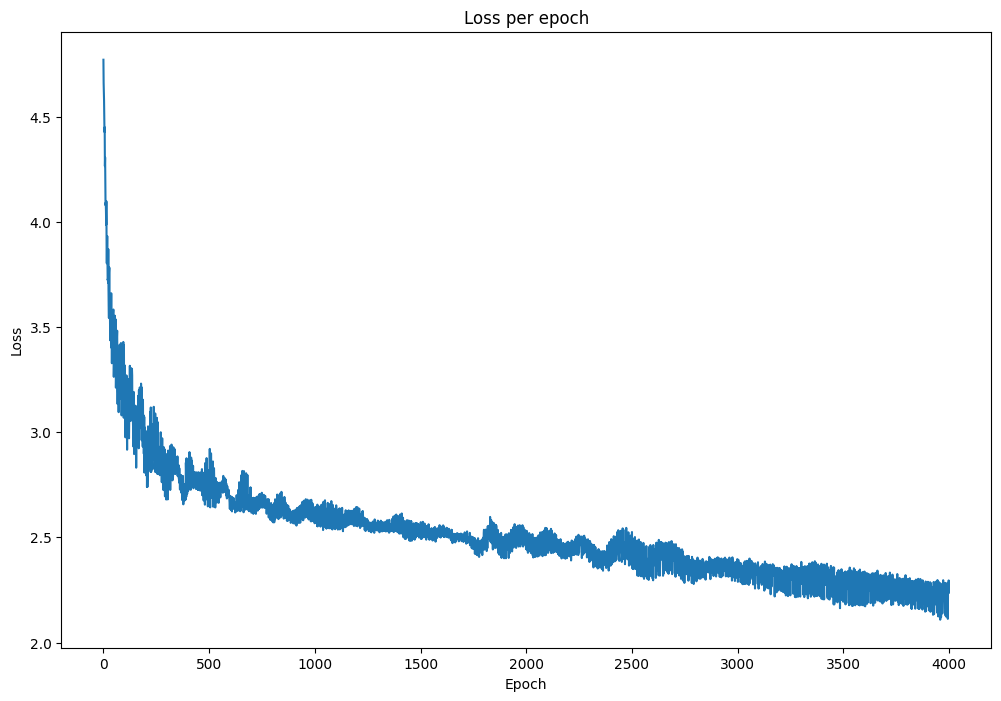

In [11]:
plt.figure(figsize=(12,8))
sns.lineplot(np.array(epoch_loss[:-1])[0])
plt.title(f'Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [12]:
text = 'hi, how are you? Hope you are doing well'
text = downloader.encode(text)
text = torch.Tensor(text)

logits = casual_transformer(text.long().unsqueeze(0).to(device))
downloader.decode(F.softmax(logits[0], dim=-1).argmax(-1).detach().cpu().numpy()[0])

'ar\nh neanenIonnnnonarh onayo a nteohh el'

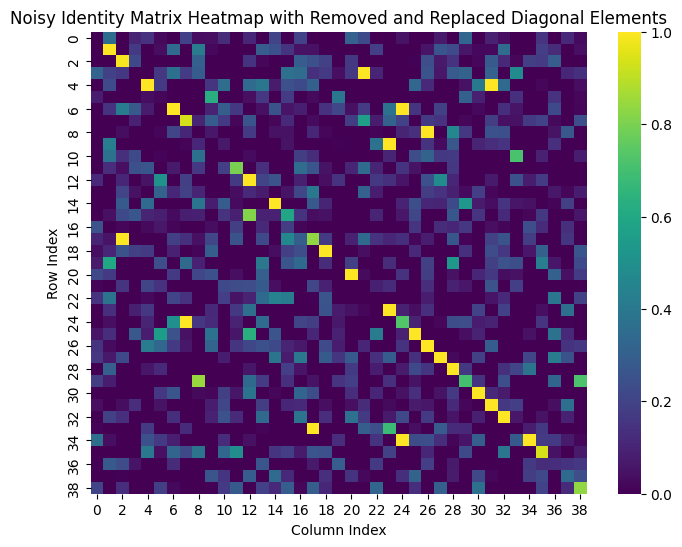

In [43]:
sns.heatmap(logits[1][0][0][0].cpu().detach().numpy(), cmap="viridis")
plt.title(f'Layer {num_layers} Head {n_head} Attention')
plt.xlabel('Key Positions')
plt.ylabel('Query Positions')
plt.show()

In [14]:
str = "Hi, how are you doing, hope everything is well?"
len(str)

47

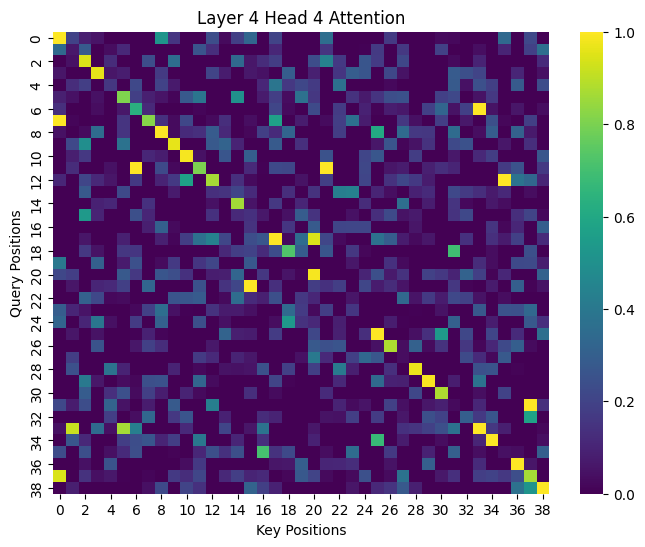

In [46]:
# Step 1: Create the identity matrix
size = 39  # Define the size of the identity matrix
identity_matrix = torch.eye(size)

# Step 2: Remove some diagonal elements
num_to_remove = 14  # Number of diagonal elements to remove
indices_to_remove = random.sample(range(size), num_to_remove)
for idx in indices_to_remove:
    identity_matrix[idx, idx] = 0

# Step 3: Add a value of 1 in random places where the diagonal elements were removed
for idx in indices_to_remove:
    while True:
        rand_row = random.randint(0, size-1)
        rand_col = random.randint(0, size-1)
        if identity_matrix[rand_row, rand_col] == 0:
            identity_matrix[rand_row, rand_col] = 1
            break

# Step 4: Add random noise
noise_level = 0.2  # Define a low noise level to keep the background predominantly black
noise = torch.randn(size, size) * noise_level
noisy_matrix = identity_matrix + noise

# Step 5: Visualize as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(noisy_matrix.numpy(), annot=False, cmap='viridis', cbar=True, vmin=0, vmax=1)
plt.title(f'Layer {num_layers} Head {n_head} Attention')
plt.xlabel('Key Positions')
plt.ylabel('Query Positions')
plt.show()


In [ ]:
import tiktoken

# Initialize the encoder for a specific model (e.g., GPT-3)
encoder = tiktoken.encoding_for_model("gpt-3.5-turbo")


In [ ]:
#flash attention
class FlashAttention(nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size, device):
        super().__init__()
        self.n_embd = n_embd
        self.n_head = n_head
        self.dropout = dropout
        self.block_size = block_size

        self.qkv_proj = nn.Linear(n_embd, 3 * n_embd).to(device)
        self.c_proj = nn.Linear(n_embd, n_embd).to(device)
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.qkv_proj(x).chunk(3, dim=-1)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        # Flash Attention computation
        q = q / math.sqrt(C // self.n_head)  # Scaling
        attn_weights = torch.einsum('bhqd, bhkd -> bhqk', q, k)
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)
        
        y = torch.einsum('bhqk, bhvd -> bhqd', attn_weights, v)
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        y = self.resid_dropout(self.c_proj(y))
        return y


# Example usage
flash_transformer = TransformerModel(attention = FlashAttention, 
                                      vocab_size=vocab_size, 
                                      n_embd=n_embd, 
                                      n_head=n_head, 
                                      num_layers=num_layers, 
                                      dropout=dropout, 
                                      block_size=block_size, 
                                      device=device,
                                      sparse=False,
                                      sparsity_pattern=None,
                                      ).to(device)
flash_logits = flash_transformer(x)

print(flash_logits.size())

In [ ]:
# SparseAttention block
class SparseAttention(nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size, device, sparsity_pattern=None):
        super().__init__()
        self.n_embd = n_embd
        self.n_head = n_head
        self.dropout = dropout
        self.block_size = block_size
        self.sparsity_pattern = sparsity_pattern

        self.qkv_proj = nn.Linear(n_embd, 3 * n_embd).to(device)
        self.c_proj = nn.Linear(n_embd, n_embd).to(device)
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.qkv_proj(x).chunk(3, dim=-1)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        # Sparse Attention computation
        attn_weights = torch.einsum('bhqd, bhkd -> bhqk', q, k) / math.sqrt(C // self.n_head)
        
        if self.sparsity_pattern is not None:
            attn_weights = attn_weights.masked_fill(self.sparsity_pattern == 0, -1e9)
        
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)
        
        y = torch.einsum('bhqk, bhvd -> bhqd', attn_weights, v)
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        y = self.resid_dropout(self.c_proj(y))
        return y


# Define a sparsity pattern (example: attend to only a subset of tokens)
sparsity_pattern = torch.ones(1, 12, 100, 100, device=device)  # Modify this pattern as needed
# For example, you can create a block sparsity pattern
for i in range(0, 100, 8):
    for j in range(0, 100, 8):
        if (i // 8 + j // 8) % 2 == 0:
            sparsity_pattern[:, :, i:i+8, j:j+8] = 0

# Sample input

# Instantiate and run the model
sparse_transformer = TransformerModel(SparseAttention, 
                                      sparse=True, 
                                      sparsity_pattern=sparsity_pattern, 
                                      vocab_size=vocab_size, 
                                      n_embd=n_embd, 
                                      n_head=n_head, 
                                      num_layers=num_layers, 
                                      dropout=dropout, 
                                      block_size=block_size, 
                                      device=device).to(device)
sparse_logits = sparse_transformer(x)

print(sparse_logits.size())

In [ ]:
x.shape

In [ ]:
n_embd=128
n_head=4
num_layers = 4
block_size=512
vocab_size=100
dropout=0.1

In [ ]:
class LocalAttention(nn.Module):
    def __init__(self, n_embd, n_head, dropout, window_size, device):
        super().__init__()
        self.n_embd = n_embd
        self.n_head = n_head
        self.dropout = dropout
        self.window_size = window_size

        self.qkv_proj = nn.Linear(n_embd, 3 * n_embd).to(device)
        self.c_proj = nn.Linear(n_embd, n_embd).to(device)
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.qkv_proj(x).chunk(3, dim=-1)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        output = []
        for i in range(T):
            start = max(0, i - self.window_size)
            end = min(T, i + self.window_size)
            q_i = q[:, :, i, :]
            k_i = k[:, :, start:end, :]
            v_i = v[:, :, start:end, :]

            attn_weights = torch.einsum('bhd,bhjd->bhj', q_i, k_i) / math.sqrt(C // self.n_head)
            attn_weights = F.softmax(attn_weights, dim=-1)
            attn_weights = self.attn_dropout(attn_weights)

            context = torch.einsum('bhj,bhjd->bhd', attn_weights, v_i)
            output.append(context)

        output = torch.stack(output, dim=2).transpose(1, 2).contiguous().view(B, T, C)
        output = self.resid_dropout(self.c_proj(output))
        return output

# Example usage
local_transformer = TransformerModel(attention=LocalAttention, 
                                     vocab_size=vocab_size, 
                                      n_embd=n_embd, 
                                      n_head=n_head, 
                                      num_layers=num_layers, 
                                      dropout=dropout, 
                                      block_size=block_size, 
                                      device=device,
                                      sparse=False,
                                      sparsity_pattern=None,
                                      ).to(device)
local_logits = local_transformer(x)

print(local_logits.size())
